In [8]:
library(ggplot2)
library(Hmisc)
library(rstan)
options(mc.cores = parallel::detectCores()) # For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE) # To avoid recompilation of unchanged Stan programs, we recommend calling
options(warn = -1)

Loading required package: StanHeaders


rstan version 2.32.6 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)

# Exercise 1 #

• Considering the following to sets of observations taken over a fixed large time interval in two different
corps:

| $y$ death soldiers | 0 | 1 | 2 | 3 | 4 | $\geq 5$ |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| $n_{1}$ observations | 109 | 65 | 22 | 3 | 1 | 0 |
| $n_{2}$ observations | 144 | 91 | 32 | 11 | 2 | 0 |

(a) assuming a uniform prior, compute and plot the posterior distribution for λ, the death rate over
the measurement time. Determine the posterior mean, median and variance, and compute the 95%
credibility interval.

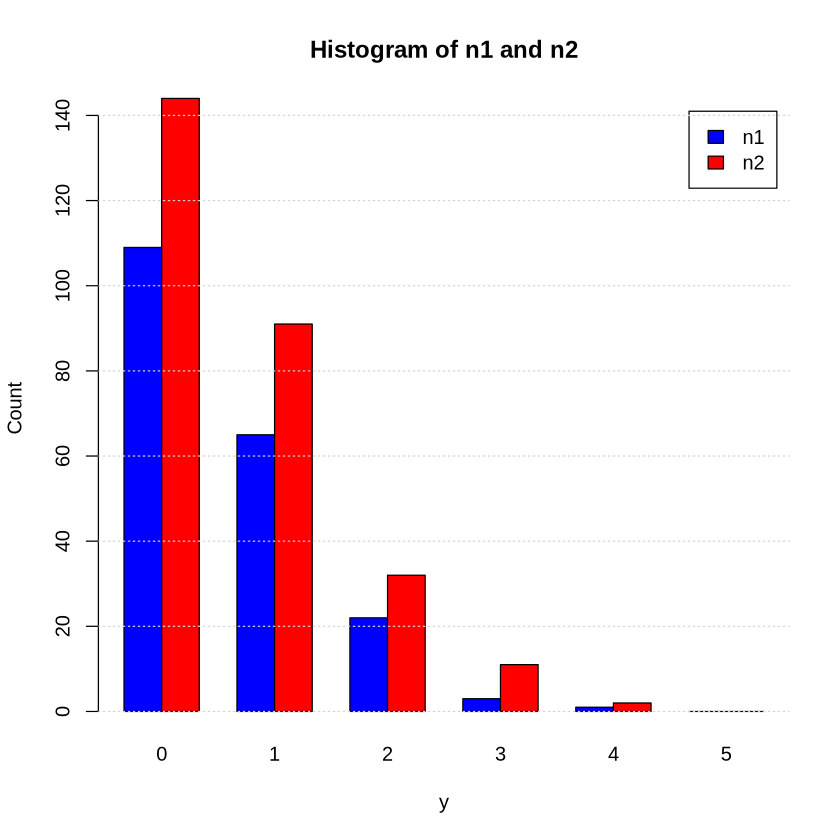

In [2]:
y <- c(0, 1, 2, 3, 4, 5)
n1 <- c(109, 65, 22, 3, 1, 0)
n2 <- c(144, 91, 32, 11, 2, 0)
n <- n1 + n2

space <- seq(0, 1.5, 0.01) # valori molto indicativi del parametro lambda, poi si mettono a posto vedendo come vengono i risultati

counts <- rbind(n1, n2)

barplot(counts, beside = TRUE, names.arg = y, col = c("blue", "red"),
        legend = c("n1", "n2"), xlab = "y", ylab = "Count", 
        main = "Histogram of n1 and n2")

grid(nx = NA, ny = NULL)

We can define the success condition as the no death condition. Therefore, the probability of observing n[0] successes is binomial process, where the probability OF THE SINGLE PROCESS is poissonian.

Mean 0.656912
Median 0.660000
Variance 0.001055
Credibility interval:0.6-0.72

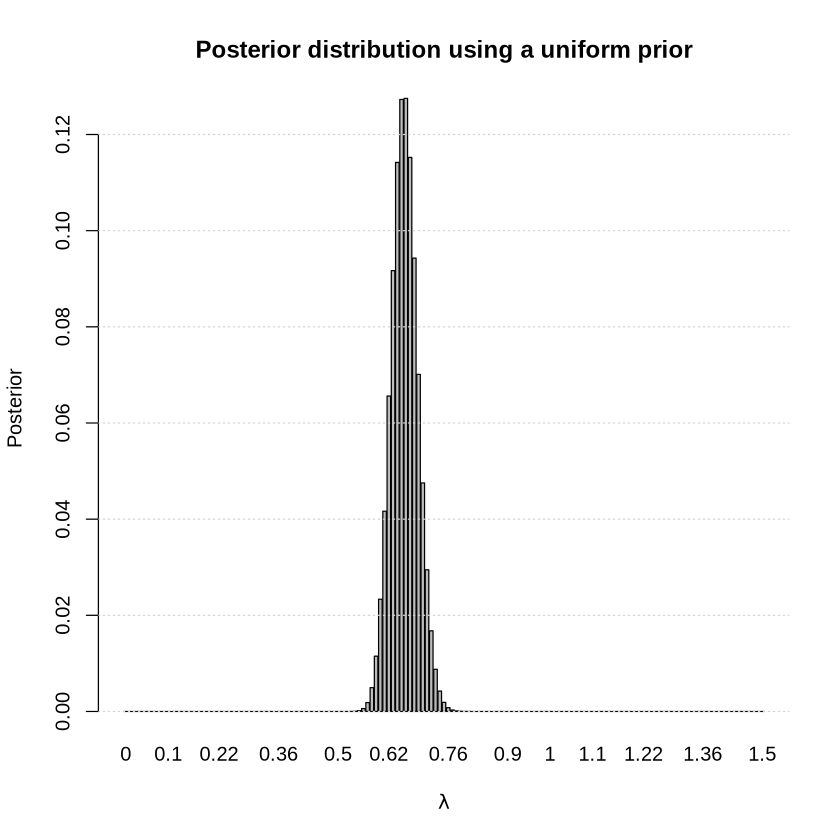

In [3]:
prior <- replicate(length(space), 1 / length(space))
prior <- prior / sum(prior)

for (i in 1:length(y)) {
    likelihood <- dbinom(n1[i], sum(n1), dpois(y[i], space))
    posterior <- prior * likelihood / sum(prior * likelihood)
    prior <- posterior
}
for (i in 1:length(y)) {
    likelihood <- dbinom(n2[i], sum(n2), dpois(y[i], space))
    posterior <- prior * likelihood / sum(prior * likelihood)
    prior <- posterior
}
barplot(posterior, names.arg = space, main = "Posterior distribution using a uniform prior",
     xlab = expression(lambda), ylab = "Posterior")

grid(nx = NA, ny = NULL)
#print(posterior)
confidence <- c(0.025, 0.975)
mean <- wtd.mean(space, posterior, normwt = TRUE)
median <- wtd.quantile(space, posterior, probs = 0.5, normwt = TRUE)
var <- wtd.var(space, posterior, normwt = TRUE)
#interval <- c(wtd.quantile(space, posterior, confidence[1], normwt = TRUE), wtd.quantile(space, posterior, confidence[1], normwt = TRUE))
interval <- wtd.quantile(space, posterior, confidence, normwt = TRUE)
cat(sprintf("Mean %3f", mean))
cat(sprintf("\nMedian %3f", median))
cat(sprintf("\nVariance %3f", var))
cat("\nCredibility interval:")
cat(interval[1])
cat("-")
cat(interval[2])

(b) assuming now a Jeffreys’ prior,
$$
g(\lambda) \propto 1 / \sqrt{\lambda}, \text { with } \lambda>0
$$

compute and plot the posterior distribution for λ, the death rate over the measurement time.
Determine the posterior mean, median and variance, and compute the 95% credibility interval

Mean 0.657603
Median 0.660000
Variance 0.001063
Credibility interval:0.603-0.72

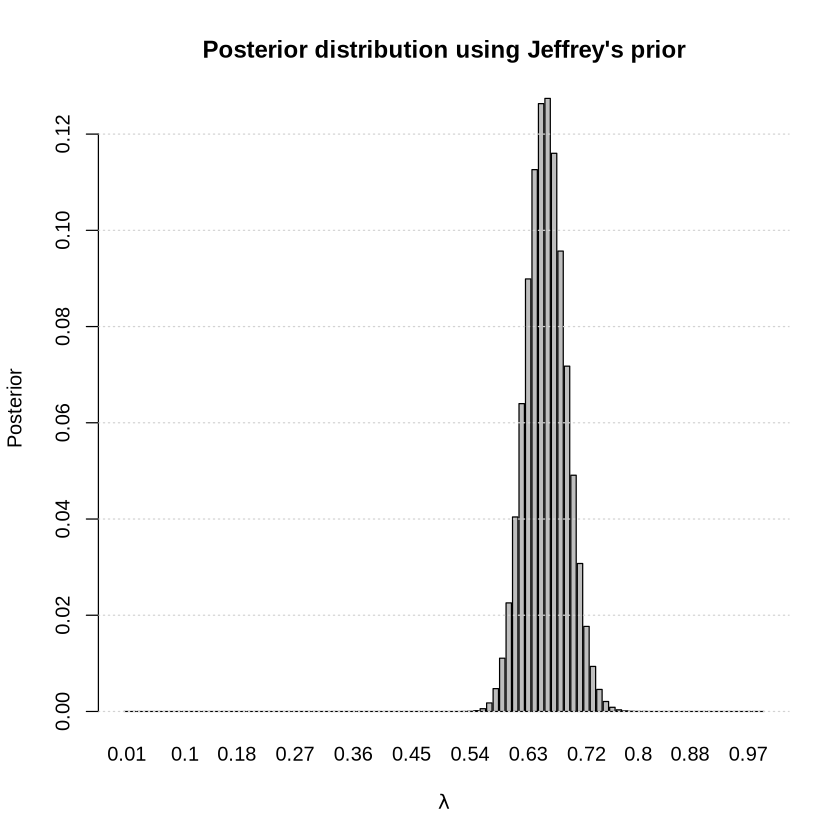

In [4]:
space <- seq(0.01, 0.99, 0.01)
prior <- dbeta(space, 0.5, 0.5)
prior <- prior / sum(prior)
#print(prior)

for (i in 1:length(y)) {
    likelihood <- dbinom(n1[i], sum(n1), dpois(y[i], space))
    posterior <- prior * likelihood / sum(prior * likelihood)
    prior <- posterior
}
for (i in 1:length(y)) {
    likelihood <- dbinom(n2[i], sum(n2), dpois(y[i], space))
    posterior <- prior * likelihood / sum(prior * likelihood)
    prior <- posterior
}
#print(posterior)
barplot(posterior, names.arg = space, main = "Posterior distribution using Jeffrey's prior",
     xlab = expression(lambda), ylab = "Posterior")

grid(nx = NA, ny = NULL)
#print(posterior)
confidence <- c(0.025, 0.975)
mean <- wtd.mean(space, posterior, normwt = TRUE)
median <- wtd.quantile(space, posterior, probs = 0.5, normwt = TRUE)
var <- wtd.var(space, posterior, normwt = TRUE)
#interval <- c(wtd.quantile(space, posterior, confidence[1], normwt = TRUE), wtd.quantile(space, posterior, confidence[1], normwt = TRUE))
interval <- wtd.quantile(space, posterior, confidence, normwt = TRUE)
cat(sprintf("Mean %3f", mean))
cat(sprintf("\nMedian %3f", median))
cat(sprintf("\nVariance %3f", var))
cat("\nCredibility interval:")
cat(interval[1])
cat("-")
cat(interval[2])

# Exercise 2 #

• solve Exercise 1 using a Markov Chain Monte Carlo using stan.

In [5]:
X <- rep(y, n) # n = n1 + n2

modelStan = '
    data {
        int<lower=0> N;
        int<lower=0> X[N];
    }
    parameters {
        real<lower=0, upper=1.5> lambda;
    }
    model {
        X ~ poisson(lambda);
        lambda ~ beta(1,1);
    }
'
mod <- stan_model(model_code = modelStan, model_name = "stan_modelR", verbose = TRUE)
fit <- sampling(mod, data = list(X = X, N = length(X)), 
    chains = 3, iter = 1000, warmup = 200, thin = 1)

stansummary = summary(object = fit)

mean <- stansummary$summary[1,1]
median <- stansummary$summary[1,6]
var <- stansummary$summary[1,3] **2
interval <- c(stansummary$summary[1,4], stansummary$summary[1,8])
cat(sprintf("Mean %3f", mean))
cat(sprintf("\nMedian %3f", median))
cat(sprintf("\nVariance %3f", var))
cat("\nCredibility interval:")
cat(interval[1])
cat("-")
cat(interval[2])


TRANSLATING MODEL 'stan_modelR' FROM Stan CODE TO C++ CODE NOW.
OS: x86_64, linux-gnu; rstan: 2.32.6; Rcpp: 1.0.12; inline: 0.3.19 
 >> setting environment variables: 
PKG_LIBS =  '/home/pietromalagoli/anaconda3/envs/asp/lib/R/library/rstan/lib//libStanServices.a' -L'/home/pietromalagoli/anaconda3/envs/asp/lib/R/library/StanHeaders/lib/' -lStanHeaders -L'/home/pietromalagoli/anaconda3/envs/asp/lib/R/library/RcppParallel/lib/' -ltbb 
PKG_CPPFLAGS =   -I"/home/pietromalagoli/anaconda3/envs/asp/lib/R/library/Rcpp/include/"  -I"/home/pietromalagoli/anaconda3/envs/asp/lib/R/library/RcppEigen/include/"  -I"/home/pietromalagoli/anaconda3/envs/asp/lib/R/library/RcppEigen/include/unsupported"  -I"/home/pietromalagoli/anaconda3/envs/asp/lib/R/library/BH/include" -I"/home/pietromalagoli/anaconda3/envs/asp/lib/R/library/StanHeaders/include/src/"  -I"/home/pietromalagoli/anaconda3/envs/asp/lib/R/library/StanHeaders/include/"  -I"/home/pietromalagoli/anaconda3/envs/asp/lib/R/library/RcppParallel/in

# Exercise 3 #

•A study on water quality of streams, a high level of bacter X was defined as a level greater than 100
per 100 ml of stream water. n = 116 samples were taken from streams having a high environmental
impact on pandas. Out of these, y = 11 had a high bacter X level.

•indicating with p the probability that a sample of water taken from the stream has a high bacter
X level

(a) find the frequentist estimator for p

(b) using a Beta(1,10) prior for p, calculate and posterior distribution $P(p∣y)$

(c) find the bayesian estimator for p, the posterior mean and variance, and a 95% credible interval

(d) test the hypotesis
$$
H_{\circ}: p=0.1 \text { versus } H_{1}: p \neq 0.1
$$

at 5% level of significance with both the frequentist and bayesian approach.

•a new measurement, performed one month later on n = 165 water samples, gives y = 9 high bacter
X level

(e) find the frequentist estimator for p

(f) find a bayesian estimator for p, assuming both a Beta(1,10) prior for p, and assuming the posterior

probability of the older measurement as the prior for the new one.

(g) find the bayesian estimator for p, the posterior mean and variance, and a 95% credible interval

(h) test the hypotesis
$$
H_{\circ}: p=0.1 \text { versus } H_{1}: p \neq 0.1
$$
at 5% level of significance with both the frequentist and bayesian approach.

######################## FIRST MEASUREMENT ##########################
The frequentist estimator for p is 0.094828Mean 0.086439
Median 0.060000
Variance 0.007332
Credibility interval:0-0.30575
######### HYPOTHESIS TEST ##########
Probability p for the frequentist approach 0.123288
Since p is higher than 0.05, we reject the hypothesis H1.

Probability p for the bayesian approach 0.036871
Since p is lower than 0.05, we reject the hypothesis H0.
######################## SECOND MEASUREMENT ##########################
The frequentist estimator for p is 0.054545

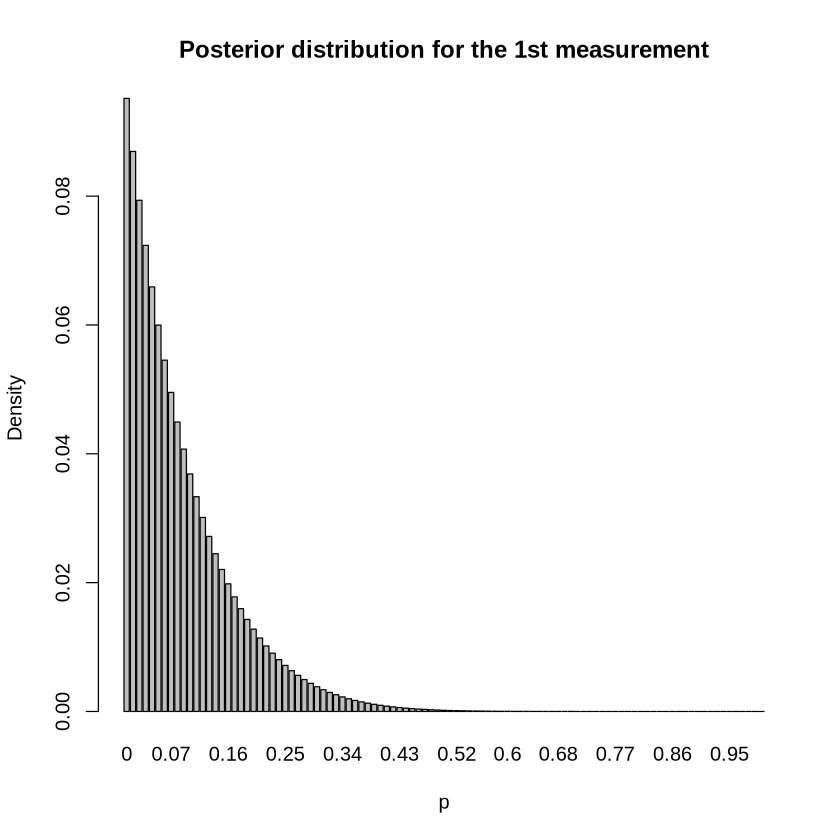

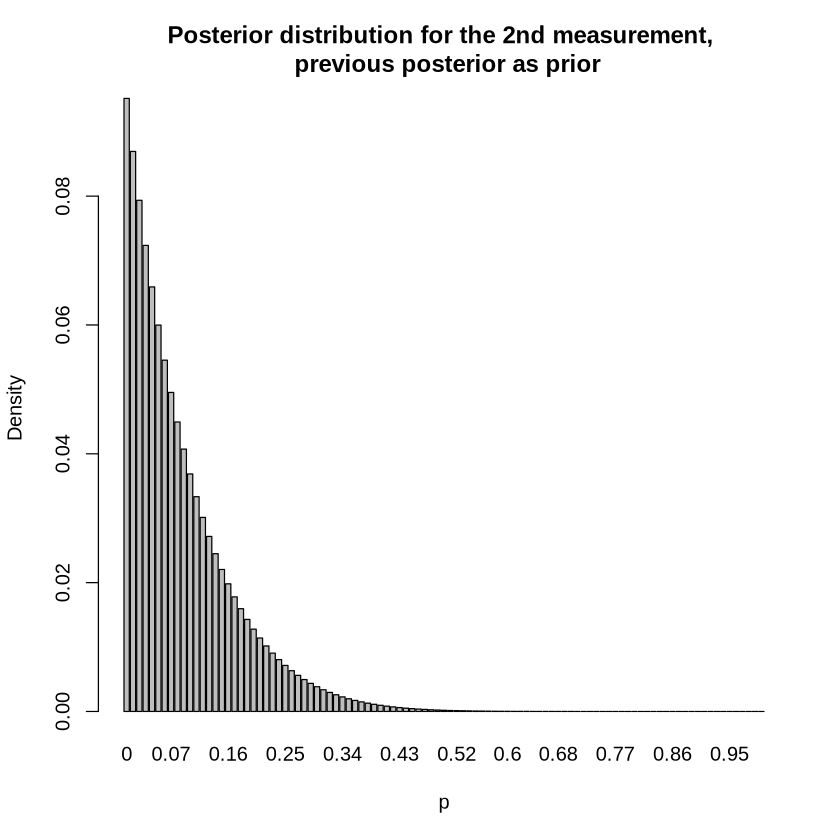

Mean 0.086439
Median 0.060000
Variance 0.007332
Credibility interval:0-0.30575
######### HYPOTHESIS TEST ##########
Probability p for the frequentist approach 0.014555
Since p is lower than 0.05, we reject the hypothesis H0.

Probability p for the bayesian approach 0.036871
Since p is lower than 0.05, we reject the hypothesis H0.


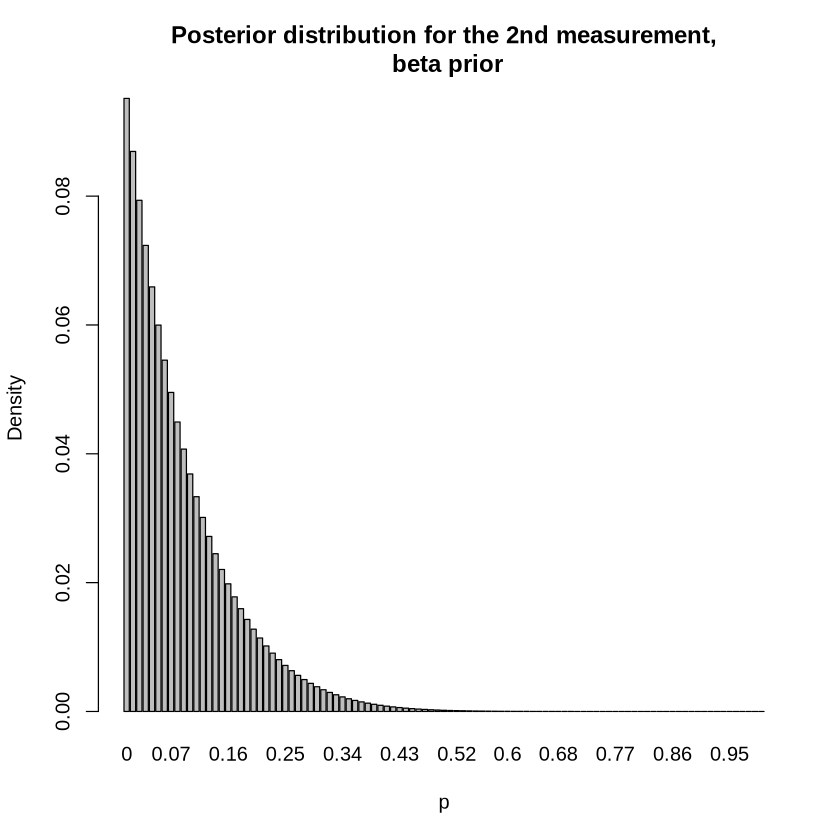

In [6]:
# a)
cat("######################## FIRST MEASUREMENT ##########################")
r <- 11
n <- 116
cat(sprintf("\nThe frequentist estimator for p is %2f", r / n))

# b)
space <- seq(0, 1, 0.01)
prior <- dbeta(space, 1, 10)
likelihood <- r / n 
posterior <- prior * likelihood / sum(prior * likelihood)
barplot(posterior, names.arg = space, xlab = "p", ylab = "Density", main = "Posterior distribution for the 1st measurement")

# c)
confidence <- c(0.025, 0.975)
mean <- wtd.mean(space, posterior, normwt = TRUE)
median <- wtd.quantile(space, posterior, probs = 0.5, normwt = TRUE)
var <- wtd.var(space, posterior, normwt = TRUE)
#interval <- c(wtd.quantile(space, posterior, confidence[1], normwt = TRUE), wtd.quantile(space, posterior, confidence[1], normwt = TRUE))
interval <- wtd.quantile(space, posterior, confidence, normwt = TRUE)
cat(sprintf("Mean %3f", mean))
cat(sprintf("\nMedian %3f", median))
cat(sprintf("\nVariance %3f", var))
cat("\nCredibility interval:")
cat(interval[1])
cat("-")
cat(interval[2])

# d) p = 0.1 at 5% 
cat("\n######### HYPOTHESIS TEST ##########")
pH = 0.1

## Frequentist
p = dbinom(r, n, pH)
cat(sprintf("\nProbability p for the frequentist approach %3f", p))
cat("\nSince p is higher than 0.05, we reject the hypothesis H1.\n")

## Bayesian
p = posterior[which(space == 0.1)]
cat(sprintf("\nProbability p for the bayesian approach %3f", p))
cat("\nSince p is lower than 0.05, we reject the hypothesis H0.\n")

### new measurement
cat("######################## SECOND MEASUREMENT ##########################")

# e)
r <- 9 
n <- 165
cat(sprintf("\nThe frequentist estimator for p is %2f", r / n))

# f)
## Previous posterior as prior 
prior <- posterior
likelihood <- r / n 
posterior_new <- prior * likelihood / sum(prior * likelihood)
barplot(posterior_new, names.arg = space, xlab = "p", ylab = "Density", main = "Posterior distribution for the 2nd measurement, \n previous posterior as prior")

## Beta prior:
prior <- dbeta(space, 1, 10)
likelihood <- r / n 
posterior_b <- prior * likelihood / sum(prior * likelihood)
barplot(posterior_b, names.arg = space, xlab = "p", ylab = "Density", main = "Posterior distribution for the 2nd measurement,\n beta prior")

# g)
# I consider the case using as prior the old posterior
confidence <- c(0.025, 0.975)
mean <- wtd.mean(space, posterior_new, normwt = TRUE)
median <- wtd.quantile(space, posterior_new, probs = 0.5, normwt = TRUE)
var <- wtd.var(space, posterior_new, normwt = TRUE)
interval <- wtd.quantile(space, posterior_new, confidence, normwt = TRUE)
cat(sprintf("Mean %3f", mean))
cat(sprintf("\nMedian %3f", median))
cat(sprintf("\nVariance %3f", var))
cat("\nCredibility interval:")
cat(interval[1])
cat("-")
cat(interval[2])

# h) p = 0.1 at 5% 
cat("\n######### HYPOTHESIS TEST ##########")
pH = 0.1

## Frequentist
p = dbinom(r, n, pH)
cat(sprintf("\nProbability p for the frequentist approach %3f", p))
cat("\nSince p is lower than 0.05, we reject the hypothesis H0.\n")

## Bayesian
p = posterior_new[which(space == 0.1)]
cat(sprintf("\nProbability p for the bayesian approach %3f", p))
cat("\nSince p is lower than 0.05, we reject the hypothesis H0.\n")


# Exerise 4 #

•analyze the data of Exercise 3 and solve points (b) and (c) using a Markov Chain Monte Carlo
using stan.

In [7]:
r <- 11
n <- 116

modelstan ='
    data {
        int<lower=0> r;
        int<lower=0> n;
    }
    parameters {
        real<lower=0,upper=1> p;
    }
    model {
        r ~ binomial(n, p);
        p ~ beta(1,10);
    }
'

mod <- stan_model(model_code = modelstan, model_name = "stan_bacteria", verbose=TRUE)
fit <- sampling(mod, data = list(X = X, N = length(X)), 
    chains = 3, iter = 1000, warmup = 200, thin = 1)

stansummary = summary(object = fit)
stansummary

mean <- stansummary$summary[1,1]
median <- stansummary$summary[1,6]
var <- stansummary$summary[1,3] **2
interval <- c(stansummary$summary[1,4], stansummary$summary[1,8])
cat(sprintf("Mean %3f", mean))
cat(sprintf("\nMedian %3f", median))
cat(sprintf("\nVariance %3f", var))
cat("\nCredibility interval:")
cat(interval[1])
cat("-")
cat(interval[2]) 


TRANSLATING MODEL 'stan_bacteria' FROM Stan CODE TO C++ CODE NOW.
OS: x86_64, linux-gnu; rstan: 2.32.6; Rcpp: 1.0.12; inline: 0.3.19 
 >> setting environment variables: 
PKG_LIBS =  '/home/pietromalagoli/anaconda3/envs/asp/lib/R/library/rstan/lib//libStanServices.a' -L'/home/pietromalagoli/anaconda3/envs/asp/lib/R/library/StanHeaders/lib/' -lStanHeaders -L'/home/pietromalagoli/anaconda3/envs/asp/lib/R/library/RcppParallel/lib/' -ltbb 
PKG_CPPFLAGS =   -I"/home/pietromalagoli/anaconda3/envs/asp/lib/R/library/Rcpp/include/"  -I"/home/pietromalagoli/anaconda3/envs/asp/lib/R/library/RcppEigen/include/"  -I"/home/pietromalagoli/anaconda3/envs/asp/lib/R/library/RcppEigen/include/unsupported"  -I"/home/pietromalagoli/anaconda3/envs/asp/lib/R/library/BH/include" -I"/home/pietromalagoli/anaconda3/envs/asp/lib/R/library/StanHeaders/include/src/"  -I"/home/pietromalagoli/anaconda3/envs/asp/lib/R/library/StanHeaders/include/"  -I"/home/pietromalagoli/anaconda3/envs/asp/lib/R/library/RcppParallel/

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
p,0.09547527,0.0009087557,0.02660975,0.04879789,0.07652472,0.09311823,0.1126222,0.1503663,857.4074,0.9989962
lp__,-40.26118467,0.0228493806,0.73346137,-42.34008037,-40.45364393,-39.97652835,-39.7775584,-39.7261022,1030.3995,1.0012205


Mean 0.095475
Median 0.093118
Variance 0.000708
Credibility interval:0.04879789-0.1503663